# CAS Machine Intelligence, Module Deep Learning
# Proof of Performance
# GAN's for City Planning
---
Furio Valerio Sordini
Winterthur, 08/11/2022
---

# Reference:
https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

# 1. Import Libraries

In [21]:
from __future__ import print_function
%matplotlib inline
import argparse #generates help messages
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel # implements data parallelism across multiple devices/GPUs
import torch.backends.cudnn as cudnn
import torch.optim as optim # optimizer for example optim.Adam([var1, var2], lr=0.0001)
import torch.utils.data # for the dataloader class (python iterable over a dataset)
import torchvision.datasets as dset # all datasets available in torch vision. not sure if needed here
import torchvision.transforms as transforms # all transformations for data augmentation (pad, resize, centercrop, ...)
import torchvision.utils as vutils # draw bounding box, segmantation mask, keypoints. convert to rgb, make grid, save_image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML # to embed html in the Ipython output

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


### Furio's Comment 
it looks like there is really one GPU

In [22]:
torch.cuda.device_count()

1

# 2. Import Data

The data are imported from kaggle. A kaggle account is necessary to download an API-key and have access to the dataset. The API is downloaded from the kaggle website as a json file and must be copied in the colab main folder.

## NOT NECESSARY
Kaggle module was not working, the data has been imported manually

In [22]:
!# pip install kaggle

/bin/bash: line 1: pip: command not found


In [23]:
# ! mkdir ~/.kaggle

mkdir: cannot create directory ‘/home/furio/.kaggle’: File exists


In [24]:
# ! cp kaggle.json ~/.kaggle/

In [25]:
# ! chmod 600 ~/.kaggle/kaggle.json

In [26]:
# ! kaggle datasets download balraj98/massachusetts-buildings-dataset

/bin/bash: line 1: kaggle: command not found


In [28]:
# ! unzip massachusetts-buildings-dataset.zip

Archive:  massachusetts-buildings-dataset.zip
  inflating: label_class_dict.csv    
  inflating: metadata.csv            
  inflating: png/test/22828930_15.png  
  inflating: png/test/22828990_15.png  
  inflating: png/test/22829050_15.png  
  inflating: png/test/23429020_15.png  
  inflating: png/test/23429080_15.png  
  inflating: png/test/23578960_15.png  
  inflating: png/test/23579005_15.png  
  inflating: png/test/23729035_15.png  
  inflating: png/test/23879080_15.png  
  inflating: png/test/24179065_15.png  
  inflating: png/test_labels/22828930_15.png  
  inflating: png/test_labels/22828990_15.png  
  inflating: png/test_labels/22829050_15.png  
  inflating: png/test_labels/23429020_15.png  
  inflating: png/test_labels/23429080_15.png  
  inflating: png/test_labels/23578960_15.png  
  inflating: png/test_labels/23579005_15.png  
  inflating: png/test_labels/23729035_15.png  
  inflating: png/test_labels/23879080_15.png  
  inflating: png/test_labels/24179065_15.png  
  inflat

Removing unnecessary folders: the original dataset is used for a classification problem. Including the folders with label images in the GAN problem would confuse the learning algorithm

In [29]:
# !rm -rf ./png/test_labels
# !rm -rf ./png/train_labels
# !rm -rf ./png/val_labels

# 3. Set the Parameters

In [23]:
# Root directory for dataset
dataroot = "../../png/train"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 3000

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = torch.cuda.device_count()

# 4. Plot image samples

❗❗❗
## **Problem 1**
<p>The resolution of the original images is quite high (1500 x 1500 pixels), which is not optimal for a GAN process.
Moreover the whole dataset (train, validation and test) has only 151 images. </p>
<p>Pytorch offers a great solution for this problem with the **random crop** transformation. On each dataloader iteration, a random portion of the image is cropped out to generate a new partial image with the target resolution (in this case 64 x 64 pixels). This is a **data augmentation** method that also solves the resolution problem. </p>


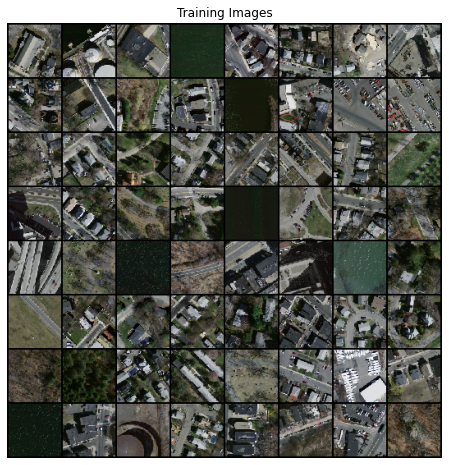

In [25]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               #transforms.Resize(image_size),
                               transforms.RandomCrop(image_size),
                               #transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)));

❗❗❗
## **Problem 2** 
Some Images are on the border of the surveyed area, therefore are completely white or black after the normalisation! 
In a successive step of this work images with empty (white) parts can be excluded from the dataset (or more desirably can be filtered out from the dataloader)

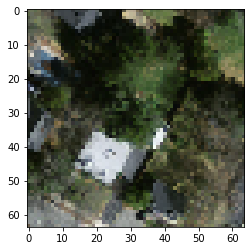

In [26]:
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[39], normalize=True).cpu(), (1,2,0)));

# 5. Custom Weights Initialization

In [27]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02) # fills the weights? gamma param with normal distribution
        nn.init.constant_(m.bias.data, 0) # fills the bias with the constant 0

# 6. Generator

In [28]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution with dimensions c=nz, h=1, w=1
            nn.ConvTranspose2d(in_channels=nz, #deconvolution!
                               out_channels=ngf * 8, 
                               kernel_size=4, 
                               stride=1, 
                               padding=0, 
                               bias=False), #no learnable bias 
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(in_channels=ngf * 8, 
                               out_channels=ngf * 4, 
                               kernel_size=4, 
                               stride=2, 
                               padding=1, 
                               bias=False),
            nn.BatchNorm2d(ngf * 4), # accelerates the learning rate by 14 times
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(in_channels=ngf * 4, 
                               out_channels=ngf * 2, 
                               kernel_size=4, 
                               stride=2, 
                               padding=1, 
                               bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(in_channels=ngf * 2, 
                               out_channels=ngf, 
                               kernel_size=4, 
                               stride=2, 
                               padding=1, 
                               bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(in_channels=ngf, 
                               out_channels=nc, 
                               kernel_size=4, 
                               stride=2, 
                               padding=1, 
                               bias=False),
            nn.Tanh() # since the desired output is in range of -1 and +1 (impossible with ReLU and sigmoid D[0,1])
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [29]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(module=netG, devide_ids=list(range(ngpu))) # recommended to use DistributedDataParallel instead

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


# 7. Discriminator

In [30]:
from torch.nn.modules.pooling import MaxPool2d
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(in_channels=nc, 
                      out_channels=ndf, 
                      kernel_size=4, 
                      stride=2, 
                      padding=1, 
                      bias=False), # (64-4+2)/2 + 1=32
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(in_channels=ndf, 
                      out_channels=ndf * 2, 
                      kernel_size=4, 
                      stride=2, 
                      padding=1, 
                      bias=False), # (32-4+2)/2+1=16
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(in_channels=ndf * 2, 
                      out_channels=ndf * 4, 
                      kernel_size=4, 
                      stride=2, 
                      padding=1, 
                      bias=False), #(16-4+2)/2+1=8
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(in_channels=ndf * 4, 
                      out_channels=ndf * 8, 
                      kernel_size=4, 
                      stride=2, 
                      padding=1, 
                      bias=False), #(8-4+2)/2+1=4
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(in_channels=ndf * 8, 
                      out_channels=1, 
                      kernel_size=4, 
                      stride=1, 
                      padding=0, 
                      bias=False), #(4-4)/2+1=1
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [31]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


# 8. Model Training

In [32]:
# Initialize BCELoss function
criterion = nn.BCELoss() #binary cross entropy, adapt for a probability output and for sigmoid function in D

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

❗❗❗
## **Problem 3**
The example cited starts with a dataset with more than **220'000** images and iterates over **5** epochs over **1'583** batches with **128** **64x64** pixels RGB images (3 channels). The computational power required by the exercise is meaningful and out of reach for a free colab set-up.
To reach a comparable training cycle with this dataset the epochs parameter should be set to 7'900

<p>In the first naive experiment I kept the number of epochs like in the original example (5). The training period was managable (few minutes) but the fake images were hardly distinguishable from a noise pattern. </p>
<p>On a second moment the number of epochs raised to 100 (still far away from a sufficient training cycle). The training period jumped to <b>42 minutes</b>, the fake images were still a noisy pattern, but some structure was distinguishable.</p>
<p>A third experiment with 500 epochs is running. An higher convergence in the loss functions of both generator and discriminator is expected. </p>

In [ ]:
%%time
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad() # sets all gradients to 0
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0) # number of images, usually=128, last batch=23
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device) # size, fill value
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/3000][0/1]	Loss_D: 1.6852	Loss_G: 6.3700	D(x): 0.5547	D(G(z)): 0.5670 / 0.0026
[1/3000][0/1]	Loss_D: 1.0825	Loss_G: 5.5458	D(x): 0.6483	D(G(z)): 0.3575 / 0.0056
[2/3000][0/1]	Loss_D: 0.8012	Loss_G: 6.4234	D(x): 0.8004	D(G(z)): 0.3844 / 0.0023
[3/3000][0/1]	Loss_D: 0.6718	Loss_G: 6.9616	D(x): 0.8030	D(G(z)): 0.3069 / 0.0014
[4/3000][0/1]	Loss_D: 0.5553	Loss_G: 6.6590	D(x): 0.7901	D(G(z)): 0.2181 / 0.0018
[5/3000][0/1]	Loss_D: 0.8816	Loss_G: 8.4003	D(x): 0.8616	D(G(z)): 0.4382 / 0.0004
[6/3000][0/1]	Loss_D: 0.7060	Loss_G: 7.8926	D(x): 0.7307	D(G(z)): 0.2424 / 0.0006
[7/3000][0/1]	Loss_D: 0.6237	Loss_G: 9.2844	D(x): 0.8719	D(G(z)): 0.3191 / 0.0001
[8/3000][0/1]	Loss_D: 0.6007	Loss_G: 8.9938	D(x): 0.8047	D(G(z)): 0.2217 / 0.0002
[9/3000][0/1]	Loss_D: 0.6296	Loss_G: 9.9185	D(x): 0.8215	D(G(z)): 0.2704 / 0.0001
[10/3000][0/1]	Loss_D: 0.3212	Loss_G: 8.7732	D(x): 0.8535	D(G(z)): 0.1162 / 0.0003
[11/3000][0/1]	Loss_D: 0.5898	Loss_G: 13.1180	D(x): 0.9465	D(G(z)): 0.3

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

#9. Results

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

# 10. Real vs Fake

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()


# 11. Archive

The discriminator (and also the generator) can be built with a similar, but not identic, process

In [ ]:
## class Discriminator(nn.Module):## 

##     def __init__(self):
##         super(Discriminator, self).__init__()
##         self.ngpu = ngpu
##         # 1 input image channel, 6 output channels, 5x5 square convolution
##         # kernel
##         self.conv1 = nn.Conv2d(nc, ndf, 4,2,1)
##         self.conv2 = nn.Conv2d(ndf, ndf*2, 4,2,1)
##         self.conv3 = nn.Conv2d(ndf*2, ndf*4,4,2,1)
##         self.conv4 = nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)
##         self.conv5 = nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False)
##         self.bn1 = nn.BatchNorm2d(ndf * 2)
##         self.bn2 = nn.BatchNorm2d(ndf * 4)
##         self.bn3 = nn.BatchNorm2d(ndf * 8)
##         # an affine operation: y = Wx + b
##         # self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
##         # self.fc2 = nn.Linear(120, 84)
##         # self.fc3 = nn.Linear(84, 10)
##
##     def forward(self, x):
##         # input is (nc) x 128 x 128
##         x = self.conv1(x)
##         x = nn.LeakyReLU(0.2, inplace=True)
##         # state 1 is (ndf) x 64 x 64
##         x = self.conv2(x)
##         x = self.bn1(x)
##         x = nn.LeakyReLU(0.2, inplace=True)
##         # state 2 is (ndf * 2) x 32 x 32
##         x = self.conv3(x)
##         x = self.bn2(x)
##         x = nn.LeakyReLU(0.2, inplace=True)
##         # state 1 is (ndf * 4) x 16 x 16
##         x = self.conv4(x)
##         x = self.bn3(x)
##         x = nn.LeakyReLU(0.2, inplace=True)
##         # state 1 is (ndf * 8) x 8 x 8
##         x = self.conv5(x)
##         x = nn.Sigmoid(x)
##         # # Max pooling over a (2, 2) window
##         # x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
##         # # If the size is a square, you can specify with a single number
##         # x = F.max_pool2d(F.relu(self.conv2(x)), 2)
##         # x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
##         # x = F.relu(self.fc1(x))
##         # x = F.relu(self.fc2(x))
##         # x = self.fc3(x)
##         return x
## 
##
## net = Discriminator()
## print(net)

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [ ]:
# data[0].to(device).shape

torch.Size([46, 3, 128, 128])

In [ ]:
## for i, data in enumerate(dataloader,0):
##   netD.zero_grad()
##   real_cpu = data[0].to(device)
##   # print(real_cpu.shape)
##   b_size = real_cpu.size(0)
##   label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
##   # print(label.shape)
##   output = netD(real_cpu).view(-1)
##   print("OUTPUT SIZE: ", output.size())
##   print("LABEL SIZE: ", label.shape)

OUTPUT SIZE:  torch.Size([3200])
LABEL SIZE:  torch.Size([128])
OUTPUT SIZE:  torch.Size([3200])
LABEL SIZE:  torch.Size([128])
OUTPUT SIZE:  torch.Size([1150])
LABEL SIZE:  torch.Size([46])


In [ ]:
## for i, data in enumerate(dataloader,0):
##   netD.zero_grad()
##   real_cpu = data[0].to(device)
##   # print(real_cpu.shape)
##   b_size = real_cpu.size(0)
##   label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
##   # print(label.shape)
##   output = netD(real_cpu).view(-1)
##   print("OUTPUT SIZE: ", output.size())
##   print("LABEL SIZE: ", label.shape)

OUTPUT SIZE:  torch.Size([3200])
LABEL SIZE:  torch.Size([128])
OUTPUT SIZE:  torch.Size([3200])
LABEL SIZE:  torch.Size([128])
OUTPUT SIZE:  torch.Size([1150])
LABEL SIZE:  torch.Size([46])


# Label Size = batch_size
*## Why not the same for output?????*
#NETD() (Discriminator Function) returns too many value and not only one!!!!!!!!!!!

In [ ]:
## netD(real_cpu).view(-1).shape

torch.Size([1150])

In [ ]:
## dataset

Dataset ImageFolder
    Number of datapoints: 302
    Root location: ./png
    StandardTransform
Transform: Compose(
               Resize(size=128, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(128, 128))
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )